## Finding
* 2019 misses data on_1b, on_2b, and on_3b
* incorrect ball and strike counts in 2019
* 2019 data can't be used
* Use TimeSeriesSplit (iterators) can be used in cv=

## EDA
* More balls less fastball 'b_count'
* 2 strikes less fastball 's_2'
* Out no effect
* tie=> more fastball; ahead/behind => less fastball 'ahead' 'behind'
* Left Batter => more fastball
* Warm => less fastball
* Last play Error => less fastball
* Last play Out => more fastball
* Last play Homerun/Triple/Douple => less fastball 'last_pa_homerun' 'last_pa_double_triple'
* Last Pitch result 'last_pitch'
* Last pitch type/fastball => less fastball
* More innings less fastball

## Completed
* Data assembling
* SQL database

## To do
* Data Cleaning
* EDA


In [2]:
import pandas as pd
import numpy as np

In [200]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [569]:
# feature engineering
# type_confidence, code 
df = pd.read_sql("""SELECT pitch_type, start_speed, zone, code, type, b_score, p_score, ab_id, pitch_num,
                    b_count, s_count, outs, on_1b, on_2b, on_3b, event, inning, stand, top, 
                    weather, start_time, year                    
                    FROM scherzer
                    WHERE year != 2019;""",'sqlite:///mlb_2015_2019.db')

In [570]:
#df['xxxx'] = df['xxxx'].apply(lambda x: 'xx' if x == 'xx' else 'xx')
df['top'].replace(['FALSE','TRUE'],[0,1],inplace=True)
df['top'] = df['top'].astype('int')
df['stand'].replace(['R','L'],[0,1],inplace=True)
df.rename(columns={"stand": "left_batter"},inplace=True)
df['start_time'] = pd.to_timedelta(df['start_time']+':00')
df['day_game'] = (df['start_time'] < '16:30:00').astype('int')
#df['fastball'] = df['pitch_type'].isin(['FF','FT','FC']).astype('int')
df.insert(1, column='fastball', value = df['pitch_type'].isin(['FF','FT','FC']).astype('int'))
df = pd.concat([df,pd.get_dummies(df['b_count'],prefix='b',drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['s_count'],prefix='s',drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['outs'],prefix='o',drop_first=True)], axis=1)
df['diff'] = df['p_score'] - df['b_score']
df['ahead'] = (df['p_score'] - df['b_score'] > 0).astype('int')
df['behind'] = (df['p_score'] - df['b_score'] < 0).astype('int')
df['tempature'] = df['weather'].apply(lambda x : x[:2]).astype('int') #min 45 max 95
df['last_pitch_type'] = df['pitch_type'].shift(1)
df.loc[0,'last_pitch_type'] = 'FF'
df['last_fastball'] = df['fastball'].shift(1)
df.loc[0,'last_fastball'] = 1
df['last_code'] = df['code'].shift(1)
df.loc[0,'last_code'] = 'X'
df['last_type'] = df['type'].shift(1)
df.loc[0,'last_type'] = 'X'
df['last_b'] = df['last_type'].isin(['B']).astype('int')
df['last_s'] = df['last_type'].isin(['S']).astype('int')
df['last_inplay'] = df['last_type'].isin(['X']).astype('int')
df['last_contact'] = df['last_type'].isin(['F','T','L','R','X','D','E']).astype('int')
df['last_pitch'] = df['last_code'].map({'B':'B','*B':'B','S':'S','C':'S','F':'S','T':'S','L':'S',
                                       'I':'B','W':'S','M':'S','P':'B','Q':'S','R':'S','X':'X',
                                       'D':'H','E':'R','H':'B','V':'B'})
df_pa = pd.read_csv('data/atbats.csv')
df_pa['last_pa'] = df_pa['event'].shift(1)
df_pa.loc[0,'last_pa'] = 'Strikeout'
df = pd.merge(df ,df_pa[['ab_id','last_pa']], on = 'ab_id')
df['last_pa_homerun'] = df['last_pa'].isin(['Home Run']).astype('int')
df['last_pa_double_triple'] = df['last_pa'].isin(['Double','Triple']).astype('int')
df['last_pa_so'] = df['last_pa'].isin(['Strikeout']).astype('int')
df['last_pa_bb'] = df['last_pa'].isin(['Walk','Hit By Pitch','Intent Walk']).astype('int')
df['last_pa_dp'] = df['last_pa'].isin(['Grounded Into DP','Double Play','Strikeout - DP','Sac Fly DP',
                                      'Sacrifice Bunt DP']).astype('int')
df['last_pa_out'] = df['last_pa'].isin(['Strikeout','Groundout','Flyout','Lineout','Pop Out','Forceout',
                                        'Runner Out','Bunt Groundout','Fielders Choice Out','Bunt Pop Out',
                                        'Fielders Choice','Batter Interference','Bunt Lineout',
                                        'Grounded Into DP','Double Play','Strikeout - DP','Sac Fly DP',
                                        'Sacrifice Bunt DP']).astype('int')


#df.to_csv('data/scherzer_features.csv')

In [388]:
df.code.value_counts()

B     3982
F     2687
C     2179
S     2031
X     1445
D      444
E      200
T      182
*B     174
W       80
L       57
H       34
V       15
I       14
M       10
Name: code, dtype: int64

In [415]:
df_pa.event.value_counts()

Strikeout               157128
Groundout               134893
Single                  108794
Flyout                   80731
Walk                     56894
Lineout                  44934
Pop Out                  34455
Double                   33157
Home Run                 22209
Forceout                 15112
Grounded Into DP         14717
Hit By Pitch              6938
Field Error               6390
Sac Fly                   4773
Sac Bunt                  3969
Intent Walk               3782
Triple                    3454
Double Play               1807
Runner Out                1742
Bunt Groundout            1253
Fielders Choice Out       1250
Strikeout - DP             580
Bunt Pop Out               569
Fielders Choice            395
Batter Interference        158
Catcher Interference       153
Sac Fly DP                  76
Bunt Lineout                52
Triple Play                 20
Sacrifice Bunt DP            4
Name: event, dtype: int64

In [447]:
df.sample(30)

pitch_type  fastball  start_speed  zone code type  b_score  p_score  \
1030          SL         0         86.1  14.0    S    S        0        0   
7518          FF         1         94.8   6.0    C    S        0        3   
9222          CU         0         77.4  11.0    C    S        0        2   
9681          CH         0         84.3   7.0    F    S        0        0   
7094          FF         1         93.9  12.0    C    S        1        0   
8465          SL         0         86.7   9.0    F    S        0        0   
2267          CU         0         78.1  13.0    B    B        3        3   
6986          FF         1         95.1  14.0    C    S        0        7   
8533          SL         0         86.8   9.0    S    S        0        1   
11235         CU         0         80.4   4.0    C    S        0        1   
4597          FC         1         88.5   7.0    X    X        2        7   
3777          FF         1         94.5  14.0    B    B        2        0   
9497          FF         1         94.6  12.0    B    B        0        0   
2811          FF         1         92.9  13.0    C    S        0        0   
12518         FF         1         96.1  11.0    C    S        0        1   
12418         FF         1         94.9   5.0    X    X        0        6   
8008          SL         0         84.5   5.0    C    S        0        3   
928           FF         1         94.0  14.0    B    B        0        0   
1630          CH         0         83.9  14.0    B    B        1        1   
7093          CU         0         78.0  14.0    H    B        1        0   
2192          FF         1         95.6   6.0    C    S        0        3   
7010          FF         1         92.6  11.0    B    B        1        7   
8497          FF         1         95.2   6.0    X    X        0        1   
2126          CU         0         80.0  11.0    B    B        0        1   
10085         FF         1         93.1  12.0    F    S        0        1   
10518         CH         0         84.6  13.0    B    B        0        3   
3083          CH         0         85.3  14.0   *B    B        2        1   
7601          CH         0         85.3  13.0    S    S        0        1   
4400          FF         1         92.9   9.0    S    S        2        6   
4209          CU         0         81.3  14.0    B    B        1        0   

            ab_id  pitch_num  ...  o_2  behind  ahead  tempature  last  \
1030   2015058904          2  ...    1       0      0         61     B   
7518   2017031274          2  ...    1       0      1         66     B   
9222   2017127421          1  ...    0       0      1         71     S   
9681   2017166033          2  ...    1       0      0         80     S   
7094   2017009650          1  ...    0       1      0         77     B   
8465   2017082460          4  ...    1       0      0         76     B   
2267   2015119129          4  ...    1       0      0         82     S   
6986   2017004722          8  ...    0       0      1         48     S   
8533   2017082496          1  ...    1       0      1         76     B   
11235  2018063243          2  ...    0       0      1         75     S   
4597   2016060317          3  ...    0       0      1         78     S   
3777   2016022768          2  ...    0       1      0         81     S   
9497   2017155366          2  ...    1       0      0         70     S   
2811   2015161883          1  ...    0       0      0         78     X   
12518  2018129244          4  ...    0       0      1         81     B   
12418  2018124360          4  ...    1       0      1         78     B   
8008   2017060464          1  ...    1       0      1         59     S   
928    2015053019          2  ...    0       0      0         70     S   
1630   2015089686          3  ...    0       0      0         82     S   
7093   2017009649          1  ...    0       1      0         77     S   
2192   2015119104          1  ...    1       0      1         82

In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13534 entries, 0 to 13533
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   pitch_type             13480 non-null  object         
 1   fastball               13534 non-null  int64          
 2   start_speed            13480 non-null  float64        
 3   zone                   13480 non-null  float64        
 4   code                   13534 non-null  object         
 5   type                   13534 non-null  object         
 6   b_score                13534 non-null  int64          
 7   p_score                13534 non-null  int64          
 8   ab_id                  13534 non-null  int64          
 9   pitch_num              13534 non-null  int64          
 10  b_count                13534 non-null  int64          
 11  s_count                13534 non-null  int64          
 12  outs                   13534 non-null  int64  

In [125]:
df['pitch_type'].unique()

array(['FF', 'CH', 'SL', 'FC', 'CU', None, 'UN', 'FT'], dtype=object)

In [93]:
df.columns

Index(['pitch_type', 'start_speed', 'type_confidence', 'zone', 'code', 'type',
       'b_score', 'p_score', 'b_count', 's_count', 'outs', 'on_1b', 'on_2b',
       'on_3b', 'event', 'inning', 'left_batter', 'top', 'start_time', 'year',
       'day_game'],
      dtype='object')

In [272]:
df.pitch_type.value_counts()

FF    7117
SL    2639
CH    1856
CU    1090
FC     688
FT      89
UN       1
Name: pitch_type, dtype: int64

In [34]:
df

pitch_type  start_speed  type_confidence  zone code type  b_score  \
0             FF         90.6              2.0  13.0    C    S        0   
1             FF         93.5              2.0  11.0    F    S        0   
2             FF         94.9              2.0  11.0    B    B        0   
3             CH         86.6              2.0  14.0    B    B        0   
4             FF         94.0              2.0  11.0    B    B        0   
...          ...          ...              ...   ...  ...  ...      ...   
16307         CU         79.1              NaN   4.0    F    F        4   
16308         SL         84.8              NaN  14.0    B    B        4   
16309         FF         97.4              NaN   8.0    F    F        4   
16310         CH         84.4              NaN   9.0    D    D        4   
16311         FF         92.7              NaN   6.0    X    X        4   

       p_score  b_count  s_count  outs  on_1b  on_2b  on_3b   event  inning  \
0            0        0        0     0      0      0      0    Walk       1   
1            0        0        1     0      0      0      0    Walk       1   
2            0        0        2     0      0      0      0    Walk       1   
3            0        1        2     0      0      0      0    Walk       1   
4            0        2        2     0      0      0      0    Walk       1   
...        ...      ...      ...   ...    ...    ...    ...     ...     ...   
16307        2        0        0     2      0      0      0  Single       6   
16308        2        0        0     2      0      0      0  Single       6   
16309        2        1        0     2      0      0      0  Single       6   
16310        2        1        0     2      0      0      0  Single       6   
16311        2        0        0     2      0      0      0  Flyout       6   

      stand top start_time  year  
0         L   1      16:09  2015  
1         L   1      16:09  2015  
2         L   1      16:09  2015  
3         L   1      16:09  2015  
4         L   1      16:09  2015  
...     ...  ..        ...   ...  
16307     R   1      19:05  2019  
16308     R   1      19:05  2019  
16309     R   1      19:05  2019  
16310     R   1      19:05  2019  
16311     L   1      19:05  2019  

[16312 rows x 20 columns]

In [461]:
df.year.value_counts()

2016    3563
2018    3503
2015    3359
2017    3109
Name: year, dtype: int64

In [177]:
df.groupby(['year','pitch_type']).count()

start_speed  zone  type  b_score  p_score  b_count  s_count  \
year pitch_type                                                                
2015 CH                  440   440   440      440      440      440      440   
     CU                  271   271   271      271      271      271      271   
     FC                   55    55    55       55       55       55       55   
     FF                 1988  1988  1988     1988     1988     1988     1988   
     SL                  598   598   598      598      598      598      598   
2016 CH                  427   427   427      427      427      427      427   
     CU                  287   287   287      287      287      287      287   
     FC                   61    61    61       61       61       61       61   
     FF                 1968  1968  1968     1968     1968     1968     1968   
     SL                  811   811   811      811      811      811      811   
     UN                    1     1     1        1        1        1        1   
2017 CH                  441   441   441      441      441      441      441   
     CU                  255   255   255      255      255      255      255   
     FC                  237   237   237      237      237      237      237   
     FF                 1415  1415  1415     1415     1415     1415     1415   
     FT                   89    89    89       89       89       89       89   
     SL                  656   656   656      656      656      656      656   
2018 CH                  548   548   548      548      548      548      548   
     CU                  277   277   277      277      277      277      277   
     FC                  335   335   335      335      335      335      335   
     FF                 1746  1746  1746     1746     1746     1746     1746   
     SL                  574   574   574      574      574      574      574   
2019 CH                  401   401   401      401      401      401      401   
     CU                  240   240   240      240      240      240      240   
     FC                  214   214   214      214      214      214      214   
     FF                 1341  1341  1341     1341     1341     1341     1341   
     SL                  573   573   573      573      573      573      573   

                 outs  on_1b  on_2b  on_3b  event  inning  left_batter   top  \
year pitch_type                                                                
2015 CH           440    440    440    440    440     440          440   440   
     CU           271    271    271    271    271     271          271   271   
     FC            55     55     55     55     55      55           55    55   
     FF          1988   1988   1988   1988   1988    1988         1988  1988   
     SL           598    598    598    598    598     598          598   598   
2016 CH           427    427    427    427    427     427          427   427   
     CU           287    287    287    287    287     287          287   287   
     FC            61     61     61     61     61      61           61    61   
     FF          1968   1968   1968   1968   1968    1968         1968  1968   
     SL           811    811    811    811    811     811          811   811   
     UN             1      1      1      1      1       1            1     1   
2017 CH           441    441    441    441    441     441          441   441   
     CU           255    255    255    255    255     255          255   255   
     FC           237    237    237    237    237     237          237   237   
     FF          1415   1415   1415   1415   1415    1415         1415  1415   
     FT            89     89     89     89     89      89           89    89   
     SL           656    656    656    656    656     656          656   656   
2018 CH           548    548    548    548    548     548          548   548   
     CU           277    277    277    277    277     277          277   277   
     FC         

In [18]:
df.columns

Index(['pitch_type', 'start_speed', 'type_confidence', 'zone', 'code', 'type',
       'b_score', 'p_score', 'b_count', 's_count', 'outs', 'on_1b', 'on_2b',
       'on_3b', 'event', 'inning', 'stand', 'top', 'start_time', 'year'],
      dtype='object')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

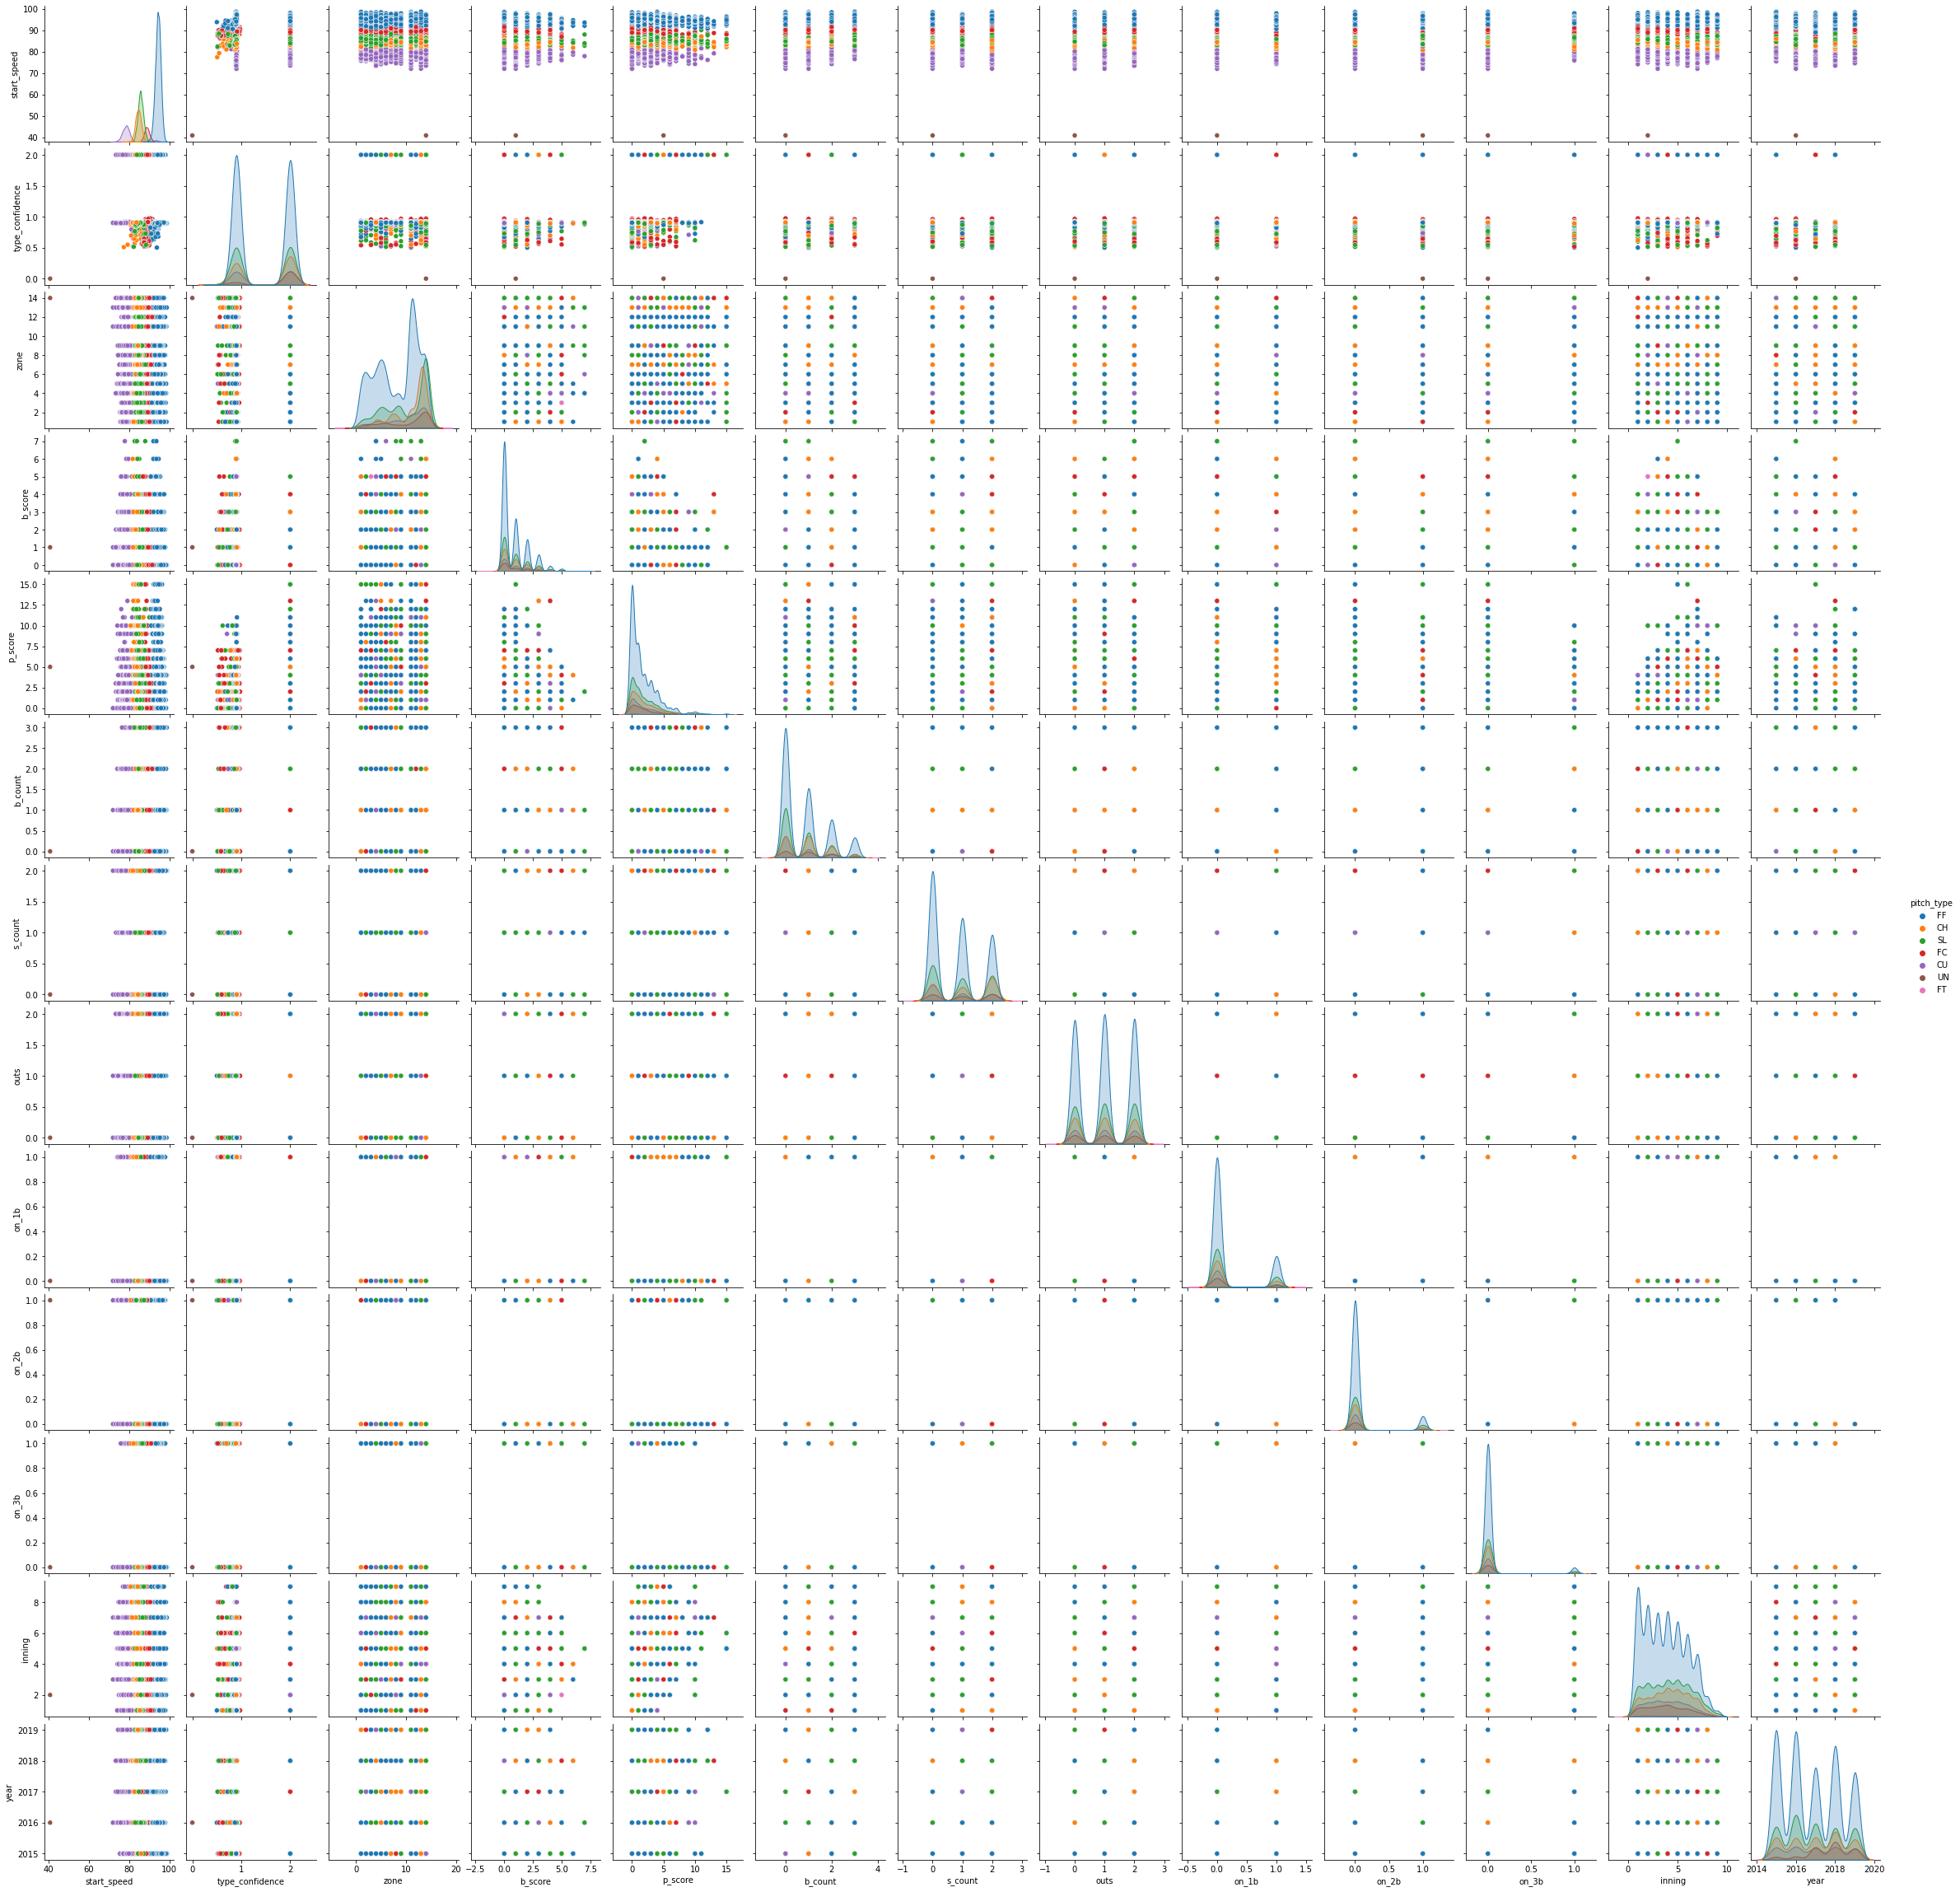

In [19]:
sns.pairplot(df, hue='pitch_type');

In [33]:
df[df['pitch_type'].isnull() & (df['event'] != 'Intent Walk')]

pitch_type  start_speed  type_confidence  zone code type  b_score  \
292         None          NaN              NaN   NaN    C    S        1   
7216        None          NaN              NaN   NaN    F    S        0   
7217        None          NaN              NaN   NaN    F    S        0   
7218        None          NaN              NaN   NaN    B    B        0   
7219        None          NaN              NaN   NaN    F    S        0   
7220        None          NaN              NaN   NaN    B    B        0   
7221        None          NaN              NaN   NaN    B    B        0   
7222        None          NaN              NaN   NaN    B    B        0   
7223        None          NaN              NaN   NaN   *B    B        0   
7224        None          NaN              NaN   NaN    X    X        0   
7994        None          NaN              NaN   NaN    F    S        0   
8434        None          NaN              NaN   NaN    S    S        0   
10875       None          NaN              NaN   NaN    F    S        0   
10880       None          NaN              NaN   NaN    X    X        0   
10897       None          NaN              NaN   NaN    F    S        0   
10909       None          NaN              NaN   NaN    F    S        1   
10926       None          NaN              NaN   NaN    F    S        1   
10938       None          NaN              NaN   NaN    C    S        1   
10940       None          NaN              NaN   NaN    F    S        1   
10941       None          NaN              NaN   NaN    B    B        1   
10943       None          NaN              NaN   NaN    F    S        1   
10955       None          NaN              NaN   NaN    F    S        1   
10965       None          NaN              NaN   NaN    S    S        1   
10967       None          NaN              NaN   NaN    X    X        1   
11672       None          NaN              NaN   NaN    B    B        1   
16187       None          NaN              NaN   NaN    B    B        2   

       p_score  b_count  s_count  outs  on_1b  on_2b  on_3b         event  \
292          7        0        0     0      0      0      0     Groundout   
7216         2        1        1     2      0      0      0          Walk   
7217         2        1        2     2      0      0      0          Walk   
7218         2        1        2     2      0      0      0          Walk   
7219         2        2        2     2      0      0      0          Walk   
7220         2        2        2     2      0      0      0          Walk   
7221         2        3        2     2      0      0      0          Walk   
7222         2        0        0     2      1      0      0       Lineout   
7223         2        1        0     2      1      0      0       Lineout   
7224         2        2        0     2      1      0      0       Lineout   
7994         3        1        1     2      0      0      0     Groundout   
8434         0        1        1     2      1      0      0     Strikeout   
10875        1        0        1     0      0      1      1     Strikeout   
10880        1        0        0     1      0      1      1       Pop Out   
10897        1        0        0     2      0      0      1     Strikeout   
10909        1        3        2     0      0      0      0     Strikeout   
10926        2        2        1     1      0      0      0     Strikeout   
10938        2        1        0     1      0      0      0       Lineout   
10940        2        1        2     1      0      0      0       Lineout   
10941        2        1        2     1      0      0      0       Lineout   
10943        2        0        0     2      0      0      0     Strikeout   
10955        2        0        2     2      0      0      0     Groundout   
10965        2        2        2     1      0      0      0     Strikeout   
10967        2        0        1     2      0      0      0  Bunt Pop Out   
11672        0        0        1     2      0      1   

In [558]:
df.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_1', 'b_2', 'b_3',
       's_1', 's_2', 'o_1', 'o_2', 'diff', 'ahead', 'behind', 'tempature',
       'last_code', 'last_type', 'last_b', 'last_s', 'last_inplay',
       'last_contact', 'last_ball', 'last_pa', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_so', 'last_pa_bb', 'last_pa_dp'],
      dtype='object')

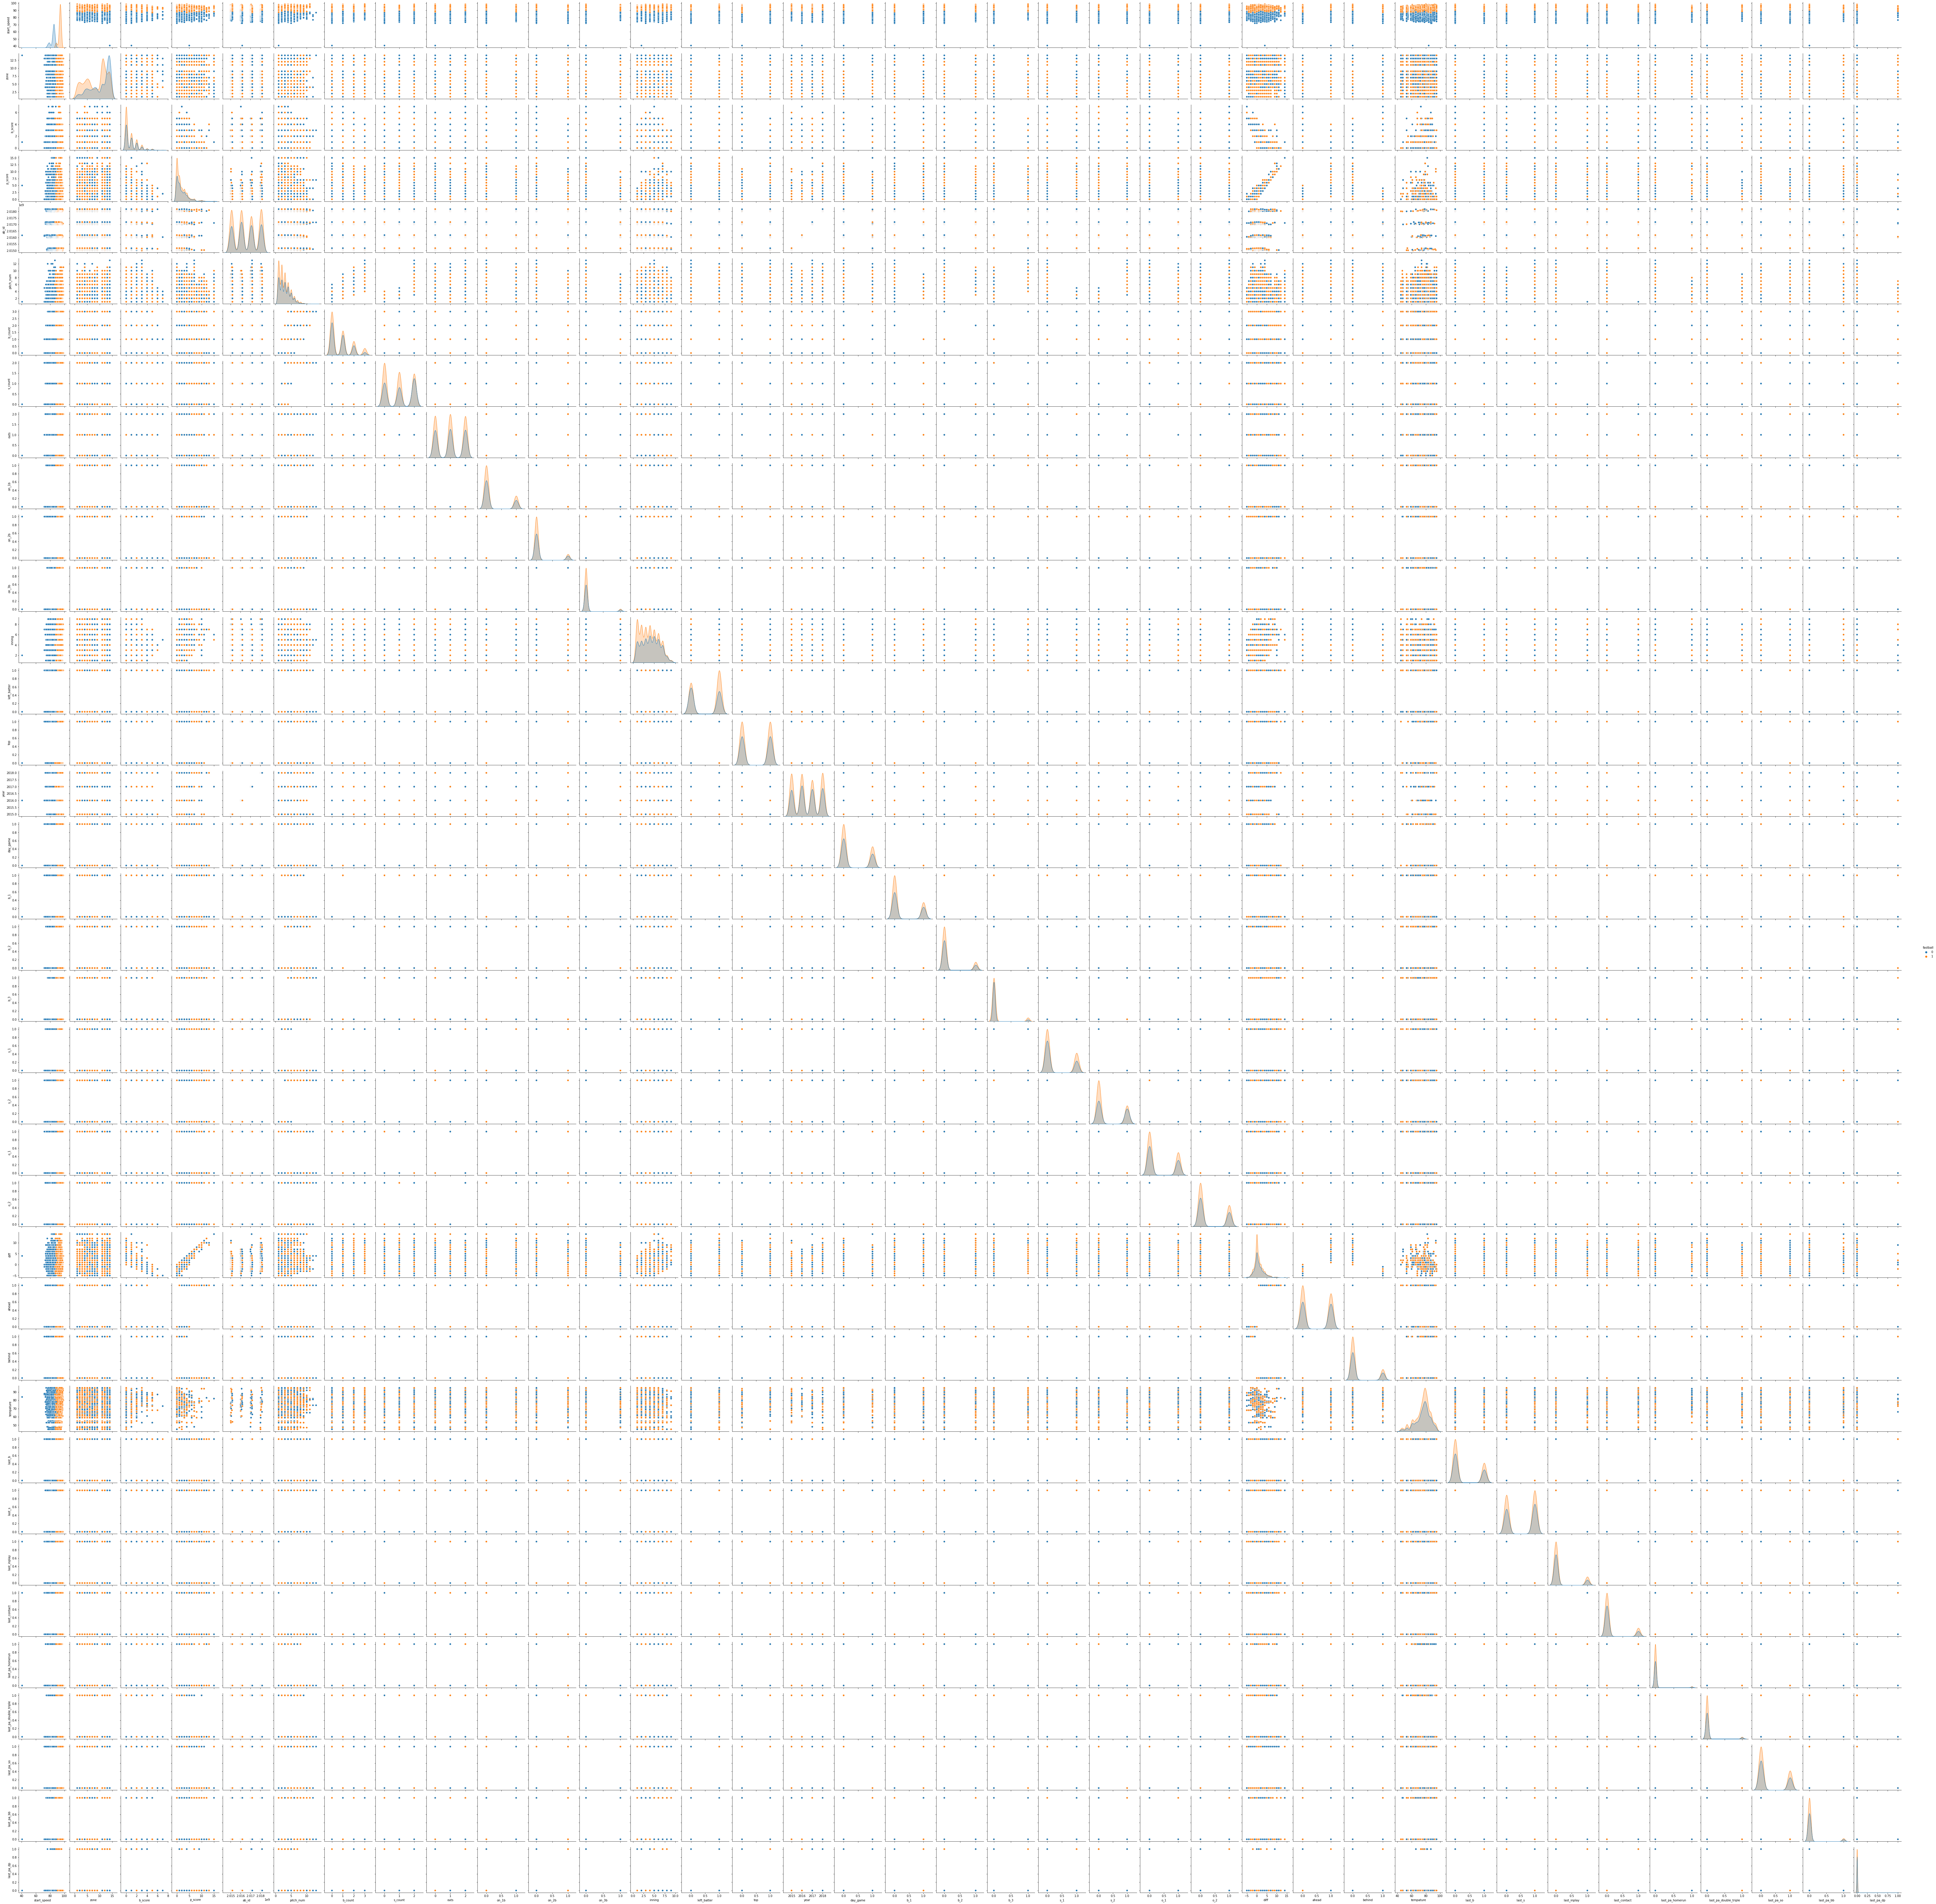

In [564]:
df_pairplot = df.dropna(how='any')[['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_1', 'b_2', 'b_3',
       's_1', 's_2', 'o_1', 'o_2', 'diff', 'ahead', 'behind', 'tempature',
       'last_code', 'last_type', 'last_b', 'last_s', 'last_inplay',
       'last_contact', 'last_ball', 'last_pa', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_so', 'last_pa_bb', 'last_pa_dp']]

sns.pairplot(df_pairplot, hue='fastball');

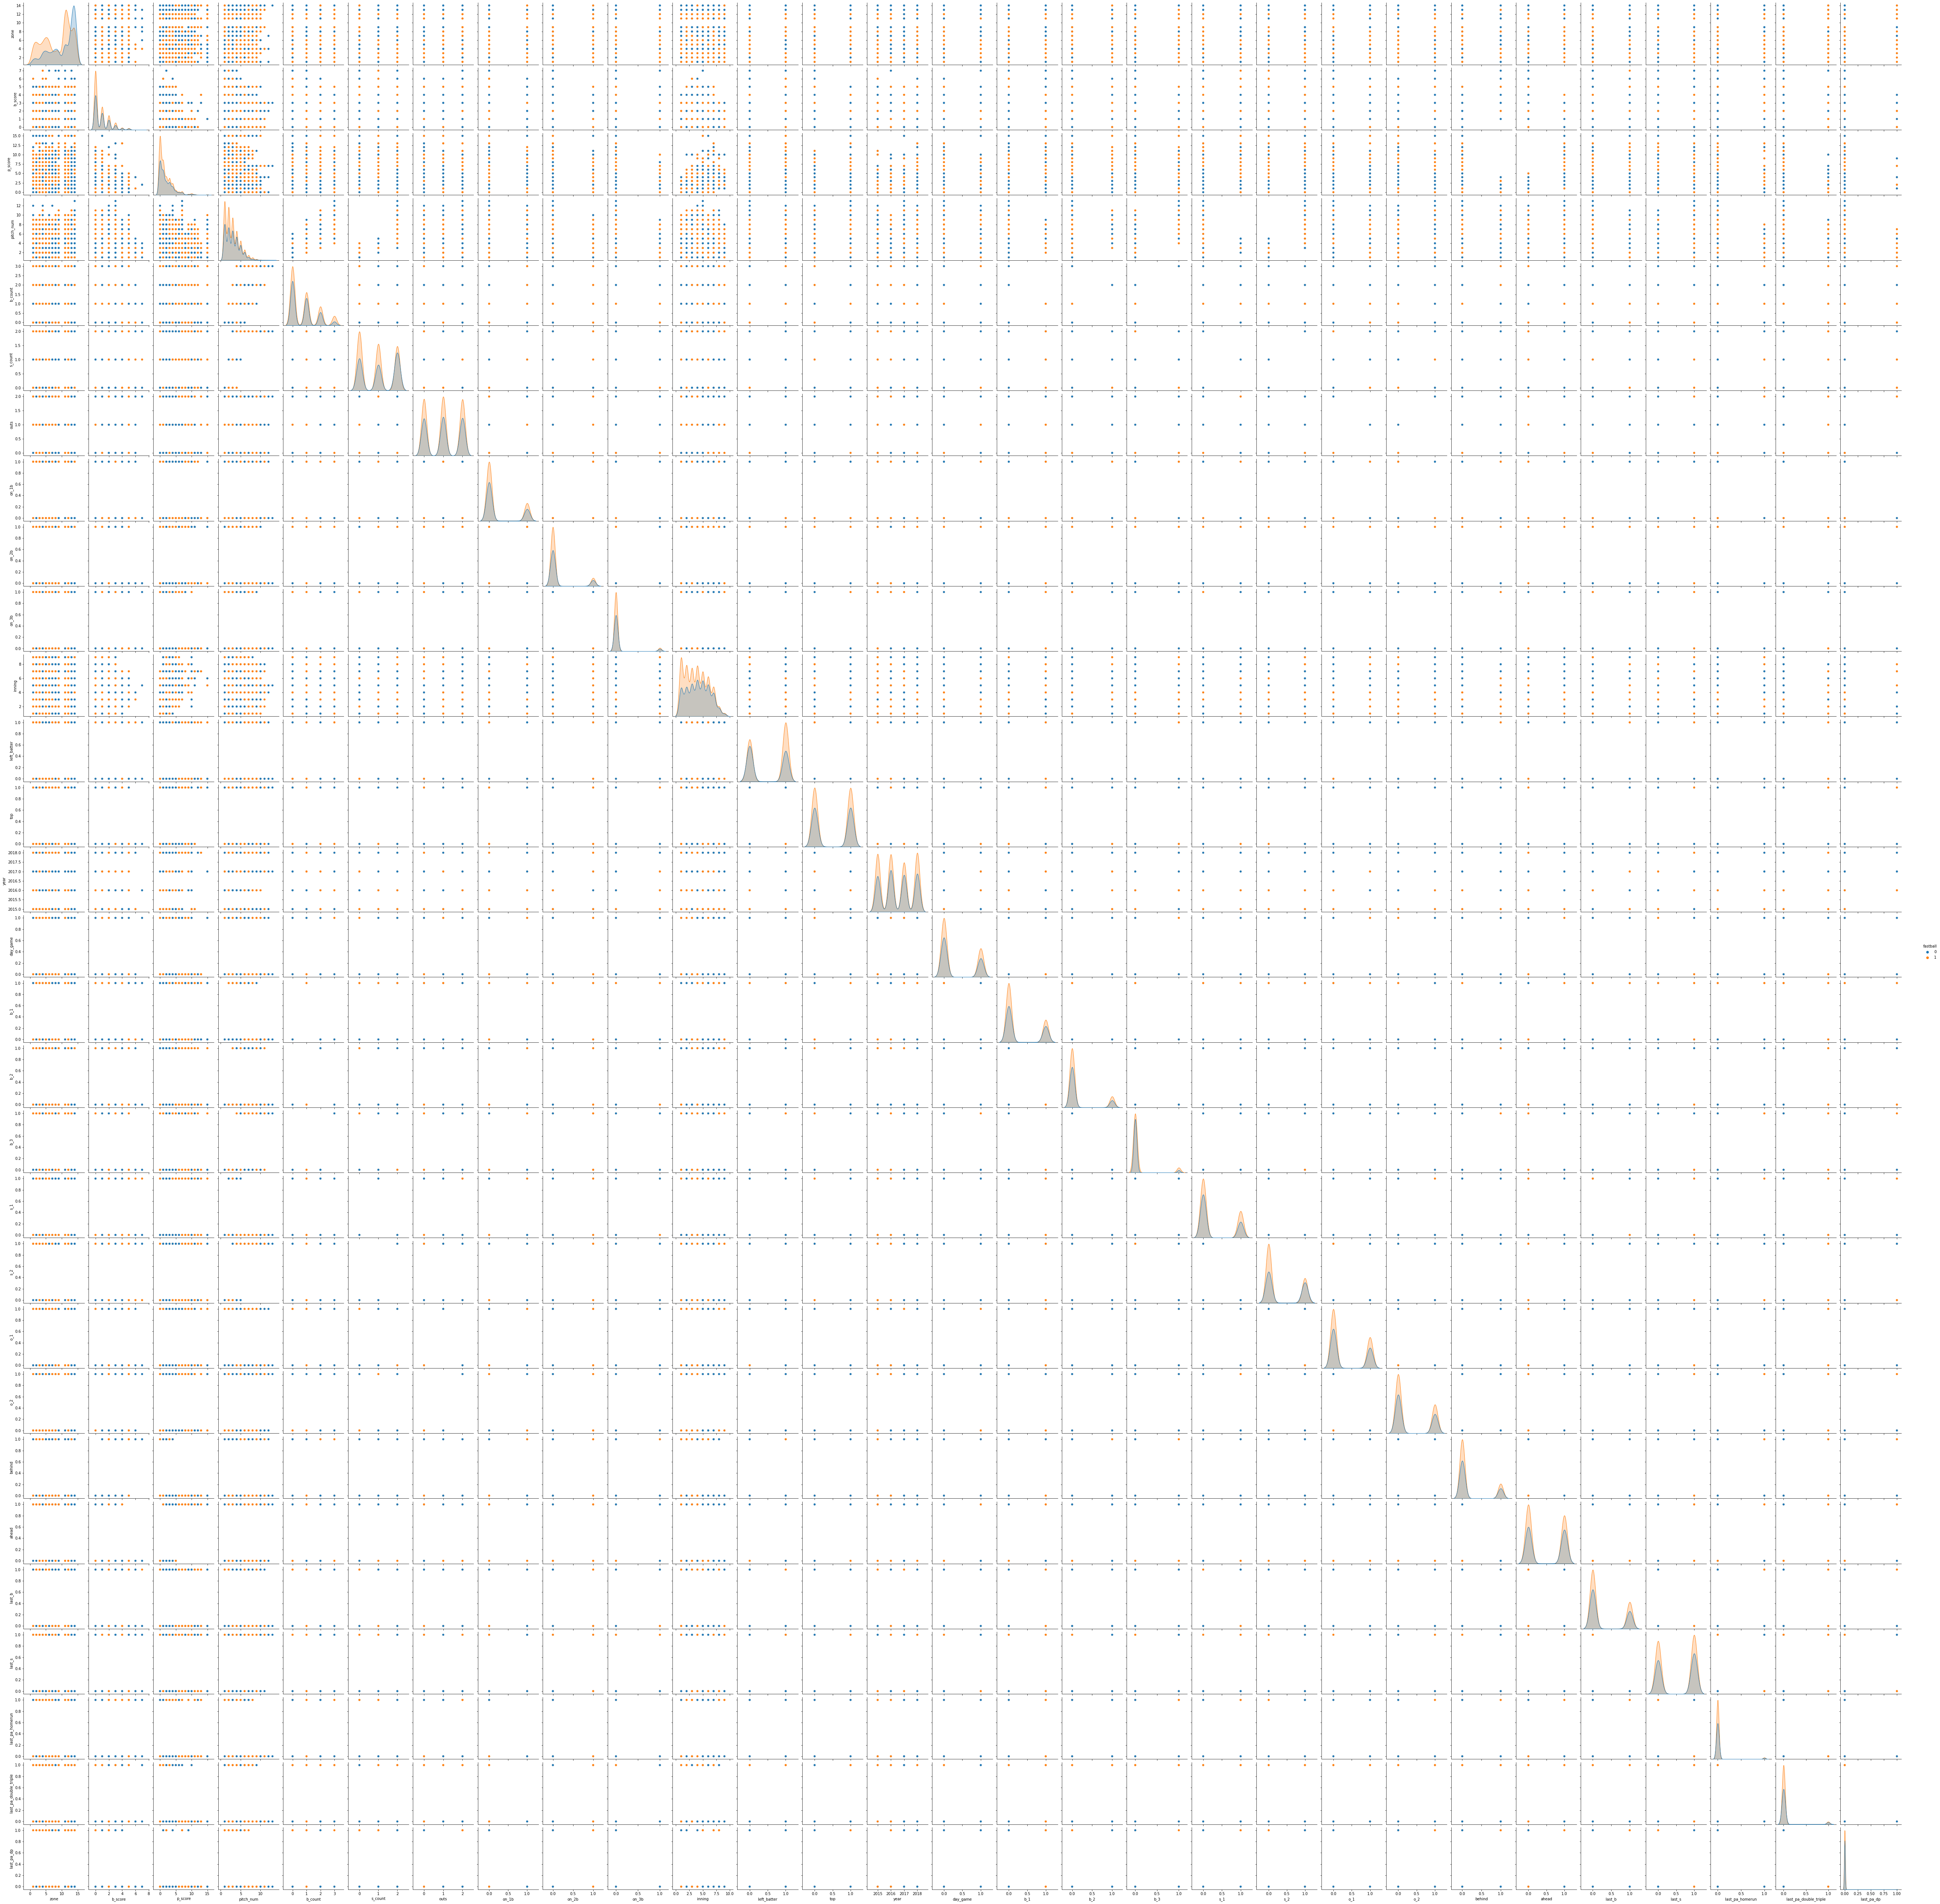

In [529]:
df_pairplot = df.dropna(how='any')[['fastball', 'zone', 'b_score', 'p_score', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'top', 'year', 'day_game', 'b_1', 'b_2', 'b_3',
       's_1', 's_2', 'o_1', 'o_2', 'behind', 'ahead', 'tempature', 
       'last_b', 'last_s', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_dp']]

sns.pairplot(df_pairplot, hue='fastball');